In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

In [3]:
ratings = pd.read_csv('/home/gbz6qn/Documents/MSDS/DS7540/project/ml-32m/ratings.csv')
movies = pd.read_csv('/home/gbz6qn/Documents/MSDS/DS7540/project/ml-32m/movies.csv')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings = ratings.sort_values(['userId', 'timestamp'])

In [30]:
#movie_embeddings = np.load('movie_embeddings.npy')
movies = pd.read_csv('movies_one_hot_genres.csv', index_col='Unnamed: 0')
user_embeddings = np.load('user_embeddings.npy')

In [31]:
movies.columns

Index(['movieId', 'title', 'No Genres Listed', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [32]:
new_index = movies['movieId']
movie_embeddings = movies[['No Genres Listed', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]

In [33]:
genres = ['No Genres Listed', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [21]:
movie_embeddings.index = new_index

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Initialize SVD for genre embeddings (choose a suitable number of components)
n_genre_components = 10  # You can experiment with this value
genre_svd = TruncatedSVD(n_components=n_genre_components)
genre_embeddings_matrix = genre_svd.fit_transform(movie_embeddings)

# Create a mapping from movieId to the index in the genre embeddings matrix
movieId_to_genre_index = {row['movieId']: index for index, row in movies[['movieId']].iterrows()}

In [47]:
np.save('genre_embeddings.npy', genre_embeddings_matrix)


In [17]:
# Load your data and embeddings:
# ratings: DataFrame with 'userId', 'movieId', 'rating'
# user_embeddings: NumPy array (num_users x embed_dim)
# movie_embeddings: NumPy array (num_movies x embed_dim)

# --- Preprocessing: Create movieId ↔ index mapping ---
unique_movie_ids = sorted(movie_embeddings['movieId'].unique())
movieId_to_index = {movie_id: idx for idx, movie_id in enumerate(unique_movie_ids)}
index_to_movieId = {idx: movie_id for movie_id, idx in movieId_to_index.items()}

# Align movie embeddings to this mapping
movie_embeddings = movie_embeddings[[movieId_to_index[m] for m in unique_movie_ids]]

In [22]:
movie_embeddings.shape

(84432, 20)

In [54]:
# --- Hyperparameters ---
EMBED_DIM = user_embeddings.shape[1]
GENRE_EMBED_DIM = genre_embeddings_matrix.shape[1]
STATE_DIM = EMBED_DIM + GENRE_EMBED_DIM
GAMMA = 0.99
LR = 1e-4
NUM_EPISODES = 1_000

# --- Define Actor-Critic Networks ---
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim, temperature=1.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        self.temperature = temperature

    def forward(self, state):
        logits = self.net(state)
        return torch.softmax(logits / self.temperature, dim=-1)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.net(state)

# --- Helper: Construct state vector ---
def get_state(user_id, history, user_embeddings, movie_embeddings, movies_df, movieId_to_genre_index, genre_embeddings_matrix):
    user_embed = torch.tensor(user_embeddings[user_id], dtype=torch.float32)
    history_genre_embed = torch.zeros(genre_embeddings_matrix.shape[1], dtype=torch.float32) # Initialize

    if history:
        history_movie_genre_embeds = []
        for movie_index in history:
            movie_id = index_to_movieId[movie_index]
            if movie_id in movieId_to_genre_index:
                genre_index = movieId_to_genre_index[movie_id]
                history_movie_genre_embeds.append(torch.tensor(genre_embeddings_matrix[genre_index], dtype=torch.float32))

        if history_movie_genre_embeds:
            history_genre_embed = torch.stack(history_movie_genre_embeds).mean(dim=0)

    return torch.cat([user_embed, history_genre_embed], dim=0)

# --- Helper: Sample a movie from action probs ---
def sample_action(probs, available_movies):
    available_movies_tensor = torch.tensor(available_movies, dtype=torch.long)
    probs_filtered = probs[available_movies_tensor]

    if probs_filtered.sum().item() == 0 or torch.any(torch.isnan(probs_filtered)):
        idx = random.randint(0, len(available_movies) - 1)
    else:
        probs_filtered /= probs_filtered.sum()
        idx = torch.multinomial(probs_filtered, 1).item()

    return available_movies[idx]

# --- Evaluation Function ---
def evaluate_policy(actor, user_embeddings, movie_embeddings, ratings, test_users, movies, movieId_to_genre_index, genre_embeddings_matrix, k=1):
    rewards = []
    for user_id in test_users:
        rated = ratings[ratings['userId'] == user_id]
        available = [movieId_to_index[m] for m in rated['movieId'] if m in movieId_to_index]
        if not available:
            continue
        state = get_state(user_id, [], user_embeddings, movie_embeddings, movies, movieId_to_genre_index, genre_embeddings_matrix)
        probs = actor(state)
        action = sample_action(probs, available)
        movie_id = index_to_movieId[action]
        reward_row = rated[rated['movieId'] == movie_id]
        if not reward_row.empty:
            rewards.append(reward_row['rating'].values[0] / 5.0)
    return np.mean(rewards) if rewards else 0.0

[Ep 0] Avg Reward: 6.600 | Hit Rate: 0.60
[Eval @ Ep 0] Avg Test Reward: 0.765
[Ep 10] Avg Reward: 7.440 | Hit Rate: 0.89
[Ep 20] Avg Reward: 8.180 | Hit Rate: 0.96
[Ep 30] Avg Reward: 7.770 | Hit Rate: 0.98
[Ep 40] Avg Reward: 7.300 | Hit Rate: 0.84
[Ep 50] Avg Reward: 7.640 | Hit Rate: 0.85
[Eval @ Ep 50] Avg Test Reward: 0.786
[Ep 60] Avg Reward: 7.730 | Hit Rate: 0.92
[Ep 70] Avg Reward: 8.360 | Hit Rate: 0.91
[Ep 80] Avg Reward: 7.810 | Hit Rate: 0.97
[Ep 90] Avg Reward: 7.460 | Hit Rate: 0.87
[Ep 100] Avg Reward: 7.010 | Hit Rate: 0.83
[Eval @ Ep 100] Avg Test Reward: 0.794
[Ep 110] Avg Reward: 7.840 | Hit Rate: 0.90
[Ep 120] Avg Reward: 7.560 | Hit Rate: 0.80
[Ep 130] Avg Reward: 8.040 | Hit Rate: 0.93
[Ep 140] Avg Reward: 8.510 | Hit Rate: 0.96
[Ep 150] Avg Reward: 8.300 | Hit Rate: 1.00
[Eval @ Ep 150] Avg Test Reward: 0.794
[Ep 160] Avg Reward: 8.380 | Hit Rate: 0.88
[Ep 170] Avg Reward: 8.800 | Hit Rate: 0.97
[Ep 180] Avg Reward: 8.140 | Hit Rate: 0.93
[Ep 190] Avg Reward: 8

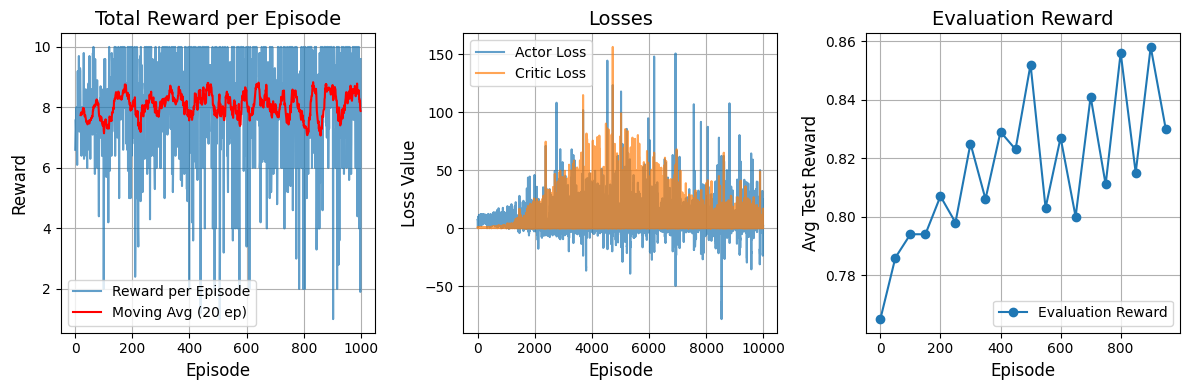

In [55]:
# --- Instantiate models and optimizers ---
actor = Actor(input_dim=STATE_DIM, output_dim=len(movie_embeddings))
critic = Critic(input_dim=STATE_DIM)
actor_optim = optim.Adam(actor.parameters(), lr=LR)
critic_optim = optim.Adam(critic.parameters(), lr=LR)

# --- Trackers ---
reward_history = []
actor_losses = []
critic_losses = []
hit_rates = []
eval_scores = []

# --- Training Loop ---
for episode in range(NUM_EPISODES):
    user_id = random.randint(0, user_embeddings.shape[0] - 1)
    rated = ratings[ratings['userId'] == user_id]
    rated_movie_ids = rated['movieId'].unique()
    available_movies = [movieId_to_index[mid] for mid in rated_movie_ids if mid in movieId_to_index]

    if len(available_movies) == 0:
        continue

    history = []
    total_reward = 0
    correct_recommendations = 0

    for t in range(10):
        state = get_state(user_id, history, user_embeddings, movie_embeddings, movies, movieId_to_genre_index, genre_embeddings_matrix)
        probs = actor(state)

        action_index = sample_action(probs, available_movies)
        movie_id = index_to_movieId[action_index]

        reward_row = rated[rated['movieId'] == movie_id]
        reward = reward_row['rating'].values[0] / 5.0 if not reward_row.empty else 0.0
        if reward >= 0.6:
            correct_recommendations += 1

        next_state = get_state(user_id, history + [action_index], user_embeddings, movie_embeddings, movies, movieId_to_genre_index, genre_embeddings_matrix)
        value = critic(state)
        next_value = critic(next_state).detach()
        td_target = reward + GAMMA * next_value
        td_error = td_target - value

        # Critic update
        critic_loss = td_error.pow(2).mean()
        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()
        critic_losses.append(critic_loss.item())

        # Actor update
        log_prob = torch.log(probs[action_index])
        actor_loss = -log_prob * td_error.detach()
        actor_optim.zero_grad()
        actor_loss.backward()
        actor_optim.step()
        actor_losses.append(actor_loss.item())

        history.append(action_index)
        total_reward += reward

    reward_history.append(total_reward)
    hit_rates.append(correct_recommendations / 10)

    if episode % 10 == 0:
        avg_reward = np.mean(reward_history[-10:])
        avg_hit = np.mean(hit_rates[-10:])
        print(f"[Ep {episode}] Avg Reward: {avg_reward:.3f} | Hit Rate: {avg_hit:.2f}")

    if episode % 50 == 0:
        test_users = random.sample(list(ratings['userId'].unique()), 100)
        eval_reward = evaluate_policy(actor, user_embeddings, movie_embeddings, ratings, test_users, movies, movieId_to_genre_index, genre_embeddings_matrix)
        eval_scores.append((episode, eval_reward))
        print(f"[Eval @ Ep {episode}] Avg Test Reward: {eval_reward:.3f}")

# --- Plotting ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(reward_history, label="Reward per Episode", alpha=0.7) # Added label and alpha
# Calculate moving average
window_size = 20
if len(reward_history) >= window_size:
    moving_avg = np.convolve(reward_history, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size - 1, len(reward_history)), moving_avg, color='red', label=f'Moving Avg ({window_size} ep)')
plt.title("Total Reward per Episode", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(actor_losses, label="Actor Loss", alpha=0.7)
plt.plot(critic_losses, label="Critic Loss", alpha=0.7)
plt.title("Losses", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

plt.subplot(1, 3, 3)
eval_x, eval_y = zip(*eval_scores)
plt.plot(eval_x, eval_y, marker='o', linestyle='-', label="Evaluation Reward") # Added markers and label
plt.title("Evaluation Reward", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Avg Test Reward", fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
torch.save(actor.state_dict(), "trained_actor_policy.pt")
plt.show()

In [56]:
# --- Load trained actor policy ---
EMBED_DIM = user_embeddings.shape[1]
GENRE_EMBED_DIM = genre_embeddings_matrix.shape[1]
actor = Actor(input_dim=STATE_DIM, output_dim=len(movie_embeddings), temperature=0.8)
actor.load_state_dict(torch.load("trained_actor_policy.pt"))
actor.eval()

# --- Build movieId → title/genre lookup ---
raw_movies = pd.read_csv('/home/gbz6qn/Documents/MSDS/DS7540/project/ml-32m/movies.csv')
movieId_to_title = dict(zip(raw_movies['movieId'], raw_movies['title']))
movieId_to_genre = dict(zip(raw_movies['movieId'], raw_movies['genres']))

# --- Helper: construct state vector with genre info ---
def get_state(user_id, history, user_embeddings, genre_embeddings_matrix, movieId_to_genre_index, index_to_movieId):
    user_embed = user_embeddings[user_id] if isinstance(user_embeddings[user_id], torch.Tensor) \
        else torch.tensor(user_embeddings[user_id], dtype=torch.float32)
    history_genre_embeds = []

    if history:
        for movie_index in history:
            movie_id = index_to_movieId[movie_index]
            if movie_id in movieId_to_genre_index:
                genre_index = movieId_to_genre_index[movie_id]
                history_genre_embeds.append(torch.tensor(genre_embeddings_matrix[genre_index], dtype=torch.float32))

        if history_genre_embeds:
            history_genre_embed = torch.stack(history_genre_embeds).mean(dim=0)
        else:
            history_genre_embed = torch.zeros(genre_embeddings_matrix.shape[1], dtype=torch.float32)
    else:
        history_genre_embed = torch.zeros(genre_embeddings_matrix.shape[1], dtype=torch.float32)

    return torch.cat([user_embed, history_genre_embed], dim=0)

# --- Helper: sample action with fallback ---
def get_state(user_id, history, user_embeddings, genre_embeddings_matrix, movieId_to_genre_index, index_to_movieId):
    user_embed = user_embeddings[user_id] if isinstance(user_embeddings[user_id], torch.Tensor) \
        else torch.tensor(user_embeddings[user_id], dtype=torch.float32)
    history_genre_embeds = []

    if history:
        for movie_index in history:
            movie_id = index_to_movieId[movie_index]
            if movie_id in movieId_to_genre_index:
                genre_index = movieId_to_genre_index[movie_id]
                history_genre_embeds.append(torch.tensor(genre_embeddings_matrix[genre_index], dtype=torch.float32))

        if history_genre_embeds:
            history_genre_embed = torch.stack(history_genre_embeds).mean(dim=0)
        else:
            history_genre_embed = torch.zeros(genre_embeddings_matrix.shape[1], dtype=torch.float32)
    else:
        history_genre_embed = torch.zeros(genre_embeddings_matrix.shape[1], dtype=torch.float32)

    return torch.cat([user_embed, history_genre_embed], dim=0)

# --- Helper: sample action with fallback ---
def sample_action(probs, available_movies):
    available_movies_tensor = torch.tensor(available_movies, dtype=torch.long)
    probs_filtered = probs[available_movies_tensor]
    if probs_filtered.sum().item() == 0 or torch.any(torch.isnan(probs_filtered)):
        idx = np.random.randint(0, len(available_movies))
    else:
        probs_filtered /= probs_filtered.sum()
        idx = torch.multinomial(probs_filtered, 1).item()
    return available_movies[idx]

# --- Interactive Recommender Session with Genre and Popular Start ---
def recommend_loop(user_embed, movie_embeddings, genre_embeddings_matrix, movieId_to_genre_index, index_to_movieId, ratings, k=10):
    history = []
    print("🎬 Starting personalized movie recommendations (with genre info and popular start!). You’ll rate 10 movies!\n")
    user_embeddings_dict = {0: user_embed}

    # --- Get top 100 rated movies ---
    top_rated_movies = ratings.groupby('movieId')['rating'].mean().nlargest(100).index.tolist()
    # Filter out movies that might not have embeddings
    available_top_rated_indices = [movieId_to_index[mid] for mid in top_rated_movies if mid in movieId_to_index]

    if not available_top_rated_indices:
        print("Warning: Could not find any top-rated movies with embeddings. Starting with a random movie.")
        first_movie_index = random.randint(0, len(movie_embeddings) - 1)
    else:
        first_movie_index = random.choice(available_top_rated_indices)

    history.append(first_movie_index)
    first_movie_id = index_to_movieId[first_movie_index]
    first_title = movieId_to_title.get(first_movie_id, f"Movie ID {first_movie_id}")
    first_genres = movieId_to_genre.get(first_movie_id, "Unknown Genre")

    print(f"🎬 First Movie (from top rated): **{first_title}**")
    print(f"📚 Genres: {first_genres}")

    while True:
        try:
            rating = float(input("⭐ Your rating (0.5 to 5.0): "))
            if 0.5 <= rating <= 5.0:
                print(f"✅ You rated: {rating}/5.0 → reward = {rating / 5.0:.2f}")
                break
            else:
                print("Please enter a rating between 0.5 and 5.0")
        except ValueError:
            print("Invalid input. Please enter a number.")

    for step in range(k - 1): # Recommend k-1 more movies after the first
        state = get_state(0, history, user_embeddings_dict, genre_embeddings_matrix, movieId_to_genre_index, index_to_movieId)
        with torch.no_grad():
            probs = actor(state)

        all_movies = list(range(len(movie_embeddings)))
        available_movies = [m for m in all_movies if m not in history]
        action_index = sample_action(probs, available_movies)
        history.append(action_index)

        movie_id = index_to_movieId[action_index]
        title = movieId_to_title.get(movie_id, f"Movie ID {movie_id}")
        genres = movieId_to_genre.get(movie_id, "Unknown Genre")

        print(f"\n📽️ Recommendation #{step + 2}: **{title}**")
        print(f"📚 Genres: {genres}")

        while True:
            try:
                rating = float(input("⭐ Your rating (0.5 to 5.0): "))
                if 0.5 <= rating <= 5.0:
                    print(f"✅ You rated: {rating}/5.0 → reward = {rating / 5.0:.2f}")
                    break
                else:
                    print("Please enter a rating between 0.5 and 5.0")
            except ValueError:
                print("Invalid input. Please enter a number.")

# --- Load genre embeddings and run session ---
genre_embeddings_matrix = np.load('/home/gbz6qn/Documents/MSDS/DS7540/project/IL/genre_embeddings.npy') # Load your saved genre embeddings
#movieId_to_genre_index_df = pd.read_csv('/home/gbz6qn/Documents/MSDS/DS7540/project/IL/movieId_to_genre_index.csv') # Load your saved mapping
#movieId_to_genre_index = dict(zip(movieId_to_genre_index_df['movieId'], movieId_to_genre_index_df['genre_index']))


# --- Define STATE_DIM correctly ---
EMBED_DIM = user_embeddings.shape[1]
GENRE_EMBED_DIM = genre_embeddings_matrix.shape[1]
STATE_DIM = EMBED_DIM + GENRE_EMBED_DIM

# --- Run session with average user embedding and genre info ---
user_embed = torch.tensor(user_embeddings.mean(axis=0), dtype=torch.float32)
recommend_loop(user_embed, movie_embeddings, genre_embeddings_matrix, movieId_to_genre_index, index_to_movieId, ratings, k=10)

🎬 Starting personalized movie recommendations (with genre info and popular start!). You’ll rate 10 movies!

🎬 First Movie (from top rated): **Fitzgerald (2002)**
📚 Genres: Drama


⭐ Your rating (0.5 to 5.0):  2.0


✅ You rated: 2.0/5.0 → reward = 0.40

📽️ Recommendation #2: **Pulp Fiction (1994)**
📚 Genres: Comedy|Crime|Drama|Thriller


⭐ Your rating (0.5 to 5.0):  4.5


✅ You rated: 4.5/5.0 → reward = 0.90

📽️ Recommendation #3: **Star Wars: Episode IV - A New Hope (1977)**
📚 Genres: Action|Adventure|Sci-Fi


⭐ Your rating (0.5 to 5.0):  3.0


✅ You rated: 3.0/5.0 → reward = 0.60

📽️ Recommendation #4: **Aliens (1986)**
📚 Genres: Action|Adventure|Horror|Sci-Fi


⭐ Your rating (0.5 to 5.0):  2.5


✅ You rated: 2.5/5.0 → reward = 0.50

📽️ Recommendation #5: **Matrix, The (1999)**
📚 Genres: Action|Sci-Fi|Thriller


⭐ Your rating (0.5 to 5.0):  2.0


✅ You rated: 2.0/5.0 → reward = 0.40

📽️ Recommendation #6: **Braveheart (1995)**
📚 Genres: Action|Drama|War


⭐ Your rating (0.5 to 5.0):  2.0


✅ You rated: 2.0/5.0 → reward = 0.40

📽️ Recommendation #7: **Lord of the Rings: The Fellowship of the Ring, The (2001)**
📚 Genres: Adventure|Fantasy


⭐ Your rating (0.5 to 5.0):  2.0


✅ You rated: 2.0/5.0 → reward = 0.40

📽️ Recommendation #8: **Shawshank Redemption, The (1994)**
📚 Genres: Crime|Drama


⭐ Your rating (0.5 to 5.0):  2.0


✅ You rated: 2.0/5.0 → reward = 0.40

📽️ Recommendation #9: **Beauty and the Beast (1991)**
📚 Genres: Animation|Children|Fantasy|Musical|Romance|IMAX


⭐ Your rating (0.5 to 5.0):  4.9


✅ You rated: 4.9/5.0 → reward = 0.98

📽️ Recommendation #10: **Ghost (1990)**
📚 Genres: Comedy|Drama|Fantasy|Romance|Thriller


⭐ Your rating (0.5 to 5.0):  5.0


✅ You rated: 5.0/5.0 → reward = 1.00
